## Parametrize Charges example

#### Import basic packages

In [1]:
import numpy as np
import pandas as pd
import electric_emission_cost.costs as costs
from electric_emission_cost.costs import (
    DEMAND, ENERGY, PEAK, HALF_PEAK, OFF_PEAK, SUPER_OFF_PEAK
)

#### Import a tariff .csv file

In [2]:
path_to_tariffsheet = "../electric_emission_cost/data/tariff.csv"
# path_to_tariffsheet = "../electric_emission_cost/tests/data/input/billing_pge.csv"
rate_df = pd.read_csv(path_to_tariffsheet, sep=",")

In [3]:
rate_df.head()

,utility,type,assessed,period,basic_charge_limit (imperial),basic_charge_limit (metric),month_start,month_end,hour_start,hour_end,weekday_start,weekday_end,charge (imperial),charge (metric),units,Notes
0,electric,customer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,666.65,666.65,$/month,https://www.pnm.com/documents/28767612/2877507...
1,electric,demand,NaN,NaN,0.0,0.0,1.0,12.0,0.0,8.0,0.0,4.0,19.79,19.79,$/kW,NaN
2,electric,demand,NaN,NaN,0.0,0.0,1.0,12.0,8.0,20.0,0.0,4.0,28.44,28.44,$/kW,NaN
3,electric,demand,NaN,NaN,0.0,0.0,1.0,12.0,20.0,24.0,0.0,4.0,19.79,19.79,$/kW,NaN
4,electric,demand,NaN,NaN,0.0,0.0,1.0,12.0,0.0,24.0,5.0,6.0,19.79,19.79,$/kW,NaN


## Specify charge variants as a list of dictionaries
### Each with entries for:
- 'scale_ratios': nested dictionary for charge scaling by period type
- 'scale_all_demand': global scaling for all demand charges
- 'scale_all_energy': global scaling for all energy charges  
- 'shift_peak_hours_before': hours to shift peak window start (must be multiple of 0.25)
- 'shift_peak_hours_after': hours to shift peak window end (must be multiple of 0.25)

The example below specifies 4 tariff variants as 4 entries in the list

In [4]:
# Each dictionary specifies a variant. See docstrings for all options.
variants = [
    # Double peak charges
    {
        'scale_ratios': {
            DEMAND: {PEAK: 2.0, HALF_PEAK: 2.0, OFF_PEAK: 1.0, SUPER_OFF_PEAK: 1.0},
            ENERGY: {PEAK: 2.0, HALF_PEAK: 2.0, OFF_PEAK: 1.0, SUPER_OFF_PEAK: 1.0}
        },
        'variant_name': 'double_peak_and_half_peak'
    },
    # Increse peak charges from specific keys
    {
        "scale_ratios": {
            "electric_demand_peak-summer": 2.2,
            "electric_demand_half_peak-summer": 2.2,
        },
        'variant_name': 'increase_peak_demand_2.2_manual'
    },
    # Halve peak charges
    {
        'scale_ratios': {
            DEMAND: {PEAK: 0.5, HALF_PEAK: 0.5, OFF_PEAK: 1.0, SUPER_OFF_PEAK: 1.0},
            ENERGY: {PEAK: 0.5, HALF_PEAK: 0.5, OFF_PEAK: 1.0, SUPER_OFF_PEAK: 1.0}
        },
        'variant_name': 'decrease_peak_and_half_peak'
    },
    # Increase all demand/energy charges
    {
        'scale_ratios': {
            DEMAND: 1.15,
            ENERGY: 1.15
        },
        'variant_name': 'increase_all'
    },
    # Expand the peak window (shift earlier start, later end)
    {
        'shift_peak_hours_before': -1.5,  # negative = earlier start (must be multiple of 0.25)
        'shift_peak_hours_after': 1.5,    # positive = later end (must be multiple of 0.25)
        'variant_name': 'expand_peak_window'
    }
]

### Specify date range to generate parametrized tariffs


In [5]:
# 1 week including 07-01 (00:00) through 07-05 (23:45)
start_dt = pd.Timestamp('2023-07-01')
end_dt = pd.Timestamp('2023-07-05')

### Generate new and baseline charge dictionaries

In [6]:
# Baseline tariff dict
base_tariff_dict = costs.get_charge_dict(start_dt=start_dt, end_dt=end_dt, rate_data=rate_df)

# Parametrized variants
new_tariff_dicts = costs.parametrize_charge_dict(
    start_dt=start_dt,
    end_dt=end_dt,
    rate_data=rate_df,
    variants=variants
)
print(new_tariff_dicts.keys())

/home/daly/git/electric-emission-cost/electric_emission_cost/costs.py:1718: UserWarning: The following charge keys were not found in scale_ratios and will use default ratio of 1.0: ['electric_demand_1', 'electric_demand_2', 'electric_demand_3', 'electric_demand_4', 'electric_energy_10', 'electric_energy_11', 'electric_energy_12', 'electric_energy_13', 'electric_energy_14', 'electric_energy_15', 'electric_energy_16', 'electric_energy_17', 'electric_energy_18', 'electric_energy_19', 'electric_energy_20', 'electric_energy_21', 'electric_energy_5', 'electric_energy_6', 'electric_energy_7', 'electric_energy_8', 'electric_energy_9']
  warnings.warn(


dict_keys(['original', 'double_peak_and_half_peak', 'increase_peak_demand_2.2_manual', 'decrease_peak_and_half_peak', 'increase_all', 'expand_peak_window'])


### Plot the energy and demand charges to visualize the parametrization

In [7]:
# make sure matplotlib is in your python environment before running this section
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

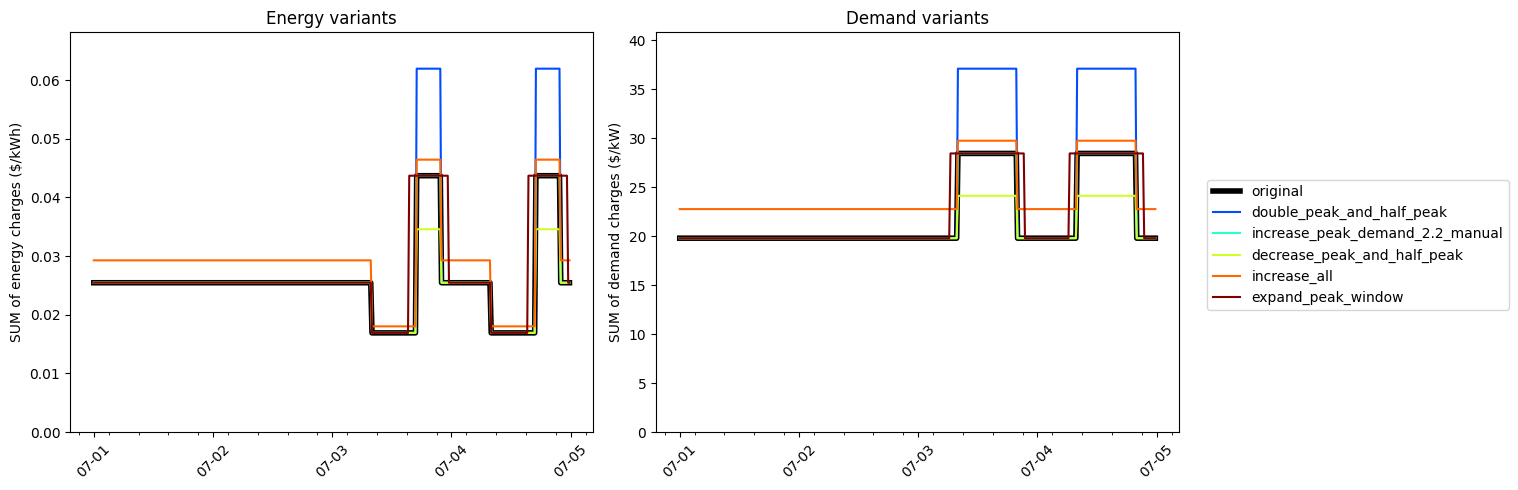

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
colors = plt.cm.jet(np.linspace(0, 1, len(new_tariff_dicts)))
colors[0] = (0, 0, 0, 1)

max_demand_charge = 0
max_energy_charge = 0

# Create time index
time_index = pd.date_range(start=start_dt, end=end_dt - pd.Timedelta(minutes=15), freq='15min')

for (variant_key, tariff_dict), color in zip(new_tariff_dicts.items(), colors):
    # Initialize arrays with the correct length
    sum_energy_array = np.zeros(len(time_index))
    sum_demand_array = np.zeros(len(time_index))
    
    for charge_key, charge_array in tariff_dict.items():
        # Skip scalar values (like customer charges)
        if not isinstance(charge_array, np.ndarray):
            continue
            
        # Only process arrays that match our time index length
        if len(charge_array) == len(time_index):
            if 'electric_energy' in charge_key:
                sum_energy_array += charge_array
            elif 'electric_demand' in charge_key:
                sum_demand_array += charge_array
    
    if variant_key == 'original':
        ax1.plot(time_index, sum_energy_array, color=color, label=variant_key, linewidth=4)
        ax2.plot(time_index, sum_demand_array, color=color, linewidth=4)
    else:
        ax1.plot(time_index, sum_energy_array, color=color, label=variant_key)
        ax2.plot(time_index, sum_demand_array, color=color)
   
    max_demand_charge = max(max_demand_charge, sum_demand_array.max())
    max_energy_charge = max(max_energy_charge, sum_energy_array.max())

# Format x-axis
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax1.set_ylim(0.0, 1.1*max_energy_charge)
ax2.set_ylim(0.0, 1.1*max_demand_charge)
ax1.set_ylabel('SUM of energy charges ($/kWh)')
ax2.set_ylabel('SUM of demand charges ($/kW)')
ax1.set_title('Energy variants')
ax2.set_title('Demand variants')

fig.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.show()